# Redes Neurais Artificiais, Tensorflow e Keras

No contexto de modelagem e aprendizado de máquina, as [redes neurais artificiais profundas](https://pt.wikipedia.org/wiki/Aprendizagem_profunda) vem tomando seu lugar no estado de arte como tecnicas de modelagem extremamente poderosas. Suas propriedaes intrínsecas permitem a estas estruturas aprenderem representações hierarquicas de alto nível baseadas nos dados de treinamento. Esta capacidade torna as redes neurais profundas ótimas estruturas de compressão de dados, com possibilidade de otimização utilizando propagação reversa dos gradientes (modelo diferenciavel), o que torna o seu treinamento eficiente e de rápida convergencia.

O Tensorflow é uma biblioteca da Google com *bindings* em Python, capaz de gerar e computar grafos matemáticos com altíssima eficiência. Esta biblioteca poderosíssima esta em constante evolução e vem sendo empregada em todos os setores da indústria.

O Keras nada mais é do que um modulo de alto nível por cima do Tensorflow, muito bom para prototipagem rápida e implementação de redes neurais artificiais.

Nesta sessão faremos uso do Keras para implementar redes neurais artificiais e utiliza-las para fazer predições sobre problemas de *Supervised Learning*.

Vamos utilizar para demonstração o clássico dataset MNIST. Este conjunto de dados consiste em imagens de digitos manuscritos de 0 a 9, com os respectivos rótulos associados. Estes ultimos serão utilizados como sinal de supervisão. Nosso objetivo é aprender o mapeamento entre os pixels da imagem e a respectiva classe (0 a 9) ao qual aquele digito pertence.

Inicialmente, vamos carregar o banco de dados do repositório de exemplos do tensorflow.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# import tensorflow_datasets as tfds
# ds_train = tfds.load(name="mnist", split="train")
# assert isinstance(ds_train, tf.data.Dataset)
# print(ds_train)

mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape

(60000, 28, 28)

In [3]:
y_train[:1]

array([5], dtype=uint8)

In [4]:
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

Desta vez, vamos utilizar o *Mini Batch Stochastic Gradient Descent* como algoritmo de otimização. Esta tecnica utiliza amostras retiradas dos dados para calcular o gradiente do erro com relação aos parâmetros do modelo e realizar a atualização dos parâmetros.

Vemos que a amostra contém três figuras de 784 pixels em um array *C-ordered*, cada uma com sua respectiva classe codificada em um array *one-hot*. São três figuras pois este foi o argumento passado ao método "next_batch".

O array *one-hot* é um tipo de codificação para variáveis multiclasse muito útil, e indica que a amostra é da classe $ i $, sendo $i$ o indice do elemento do array onde o elemento é igual a 1, ou seja, um array do tipo [0,0,1,0,0,0,0,0,0,0], por exemplo, indica que a figura representa o número 2.

As figuras podem ser visualizadas com o código a seguir:

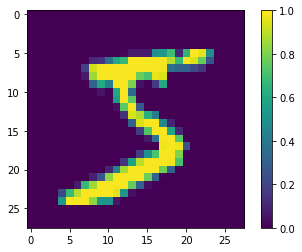

In [5]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

Para ilustrar o processo de codificar e treinar uma rede neural profunda em python, vamos utilizar o numpy como biblioteca matemática e fazer isto do rascunho para cima.

Iniciaremos declarando as funções auxiliares ao nosso processo.

- A primeira função define a estrutura do nosso modelo e inicializa suas variáveis. Uma grande variedade de inicializações pseudo-aleatórias dos pesos está disponível na literatura e o modo como se inicializa os pesos de uma rede neural profunda afeta como ela aprende. Este efeito é ligado principalmente ao fenomeno dos [*Vanishing Gradients*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), ou gradientes que desaparecem. Mais sobre este assunto mais à frente. Aqui, inicializaremos nosos pesos com distribuição normal de média zero e variancia 0.1.

### Multilayer Perceptron

In [6]:
np.random.seed(42)                                      # fixa a random seed para obter repetibilidade dos resultados

def mlp(n_in, n_hidden, n_out):                         # Funçao de inicializaçao das variaveis da rede neural

    U = np.random.normal(size=(n_hidden, n_in))         # Pesos da primeira layer (Distribuiçao normal com desvio 0.1 e shape (n_in, n_hidden)
    V = np.random.normal(size=(n_hidden, n_hidden))     # O mesmo para a segunda layer
    W = np.random.normal(size=(n_out, n_hidden))        # pesos layer de saida

    bu = np.zeros(n_hidden)                             # Inicializa bias da primeira layer
    bv = np.zeros(n_hidden)                             # mesmo segunda layer
    bw = np.zeros(n_out)                                # Bias de saída

    params = [U,V,W,bu,bv,bw]                           # transforma os parametros em lista de parametros

    return params                                       # retorna parametros

- A segunda função é a função de ativação dos neuronios a ser utilizada. Neste caso, usaremos a função sigmoid.

In [7]:
class Sigmoid:
    @classmethod
    def forward(cls, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    @classmethod
    def backward(cls, X):
        output = cls.forward(X)
        return (1.0 - output) * output

def one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

- A terceira função é a função de propagação direta da nossa rede neural, e será usada para fazer inferência.

In [8]:
def predict(x, U, V, W, bu, bv, bw):    # Realiza prediçoes com a rede neural
    A = np.dot(U, x) + bu               # Calcula a saída da layer 1 sem ativaçao
    B = np.dot(V, Sigmoid.forward(A)) + bv      # Calcula a saida da layer de dois sem ativaçao
    C = np.dot(W, Sigmoid.forward(B)) + bw      # saida layer, saida sem ativaçao
    Z = Sigmoid.forward(C)                      # ativaçao layer saida
    index = np.argmax(Z)                # adquire o index no array de 1 a 10 que corresponde ao valor da prediçao
    out = np.zeros((1, 10))             # cria array de dez valores 0
    out[0, index] = 1                   # atribui valor 1 ao valor no array cujo index corresponde a saída da layer
    return Z, out.astype(int)           # retorna probabilidade de cada valor, prediçao em one-hot

Como medida de custo, vamos utilizar a entropia relativa entre os as distribuições de probabilidade das nossas previsões e dos dados de referência.  
Ver: 
[Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy), 
[KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Cross_entropy)

In [9]:
def cross_entropy(y_hat, y):
    return -np.mean(y_hat * np.log(y) + (1 - y_hat) * np.log(1 - y))

- A quarta e última função é a função de propagação reversa da rede neural. Esta função trata de calcular os gradientes do erro em relação aos parâmetros do modelo. Utilizar estes gradientes para atualizar os pesos do modelo em questão é chamado *Gradient Descent*. Quando ele é feito em amostrar menores do *dataset*, ele se torna o *Stochastic Gradient Descent*.

In [10]:
def batch_generator(x, y, batch_size=64, n_out=10):
    idx = 0
    while True:
        yield x[idx:idx+batch_size].reshape((-1, 784)), one_hot(y[idx:idx+batch_size], n_out)
        idx += batch_size
        if idx >= x.shape[0]:
            idx=0

def train(x, y, U, V, W, bu, bv, bw): #funçao treinamento
    """
    PARAMETROS: x = input data
                V =  Pesos da primeira layer
                W =  Pesos da segunda layer
                bv = Bias da primeiralayer
                bw = Bias da segunda layer

    """
    # forward propagation
    A = np.dot(U, x) + bu   # realiza a multiplicaçao escalar da entrada pelos pesos da primeira layer
                            # e adidiona o valor do bias

    B = np.dot(V, Sigmoid.forward(A)) + bv   # realiza a multiplicaçao matricial da saida da ativaçao sigmoid da primeira layer
                                     # pelos pesos da segunda layer e adiciona os bias para esta layer
        
    C = np.dot(W, Sigmoid.forward(B)) + bw   # mesmo com a layer de saida
    
    Y = Sigmoid.forward(C)                   # ativaçao da layer de saida
    

    # backward propagation (https://en.wikipedia.org/wiki/Backpropagation)
    Ew = Y - y                                # Diferença do valor da saída predita pela saída esperada (gradiente)
    Ev = Sigmoid.backward(B) * np.dot(Ew, W)  # Calcula o erro para a layer DOIS (Gradiente do erro * pesos da segunda layer) * sigmoid(hidden))
    Eu = Sigmoid.backward(A) * np.dot(Ev, V)  # mesmo para layer um
    
    # Deltas utilizados para atualizar os pesos da rede
    dW = np.outer(Ew, Sigmoid.backward(B))    # DeltaW, Calcula a distributiva de cada termo do array e retorna lista de arrays distribuidos
    dV = np.outer(Ev, Sigmoid.backward(A))    # DeltaV  , Hadamard product
    dU = np.outer(Eu, x)                      # mesmo
    loss = cross_entropy(y, Y) #funçao loss = cross-entropy

    return  Y, loss, (dU, dV, dW, Eu, Ev, Ew)  #retorna o valor da funçao custo e o gradiente do erro em funçao dos pesos e bias

O código a seguir implementa a rotina de treinamento do modelo no *dataset* em amostras, ou *batches*. Aqui, chamamos a função *train* em cada amostra e acumulamos os gradientes durante um *batch*. Atualizamos então os pesos do nosso modelo com a subtração dos gradientes mais um valor de momento para acelerar o treinamento. Este algoritmo é uma das formas mais simples de *Stochastic Gradient Descent* e variações mais poderosas estão disponíveis na literatura e implementadas e prontas para uso em modulos de amprendizado de máquina.

In [11]:
import time

# Parametros de treinamento
epochs = 100
batch_size = 128
learning_rate = 0.001
momentum = 0.99
n_hidden = 256  #numero de neuronios nas hidden layers

# Treinamento
print("Start Training Session")

train_err = []
train_accu = []
eval_err = []
eval_accu = []

mnist_train = batch_generator(x_train, y_train, batch_size)
mnist_eval = batch_generator(x_val, y_val, batch_size)

# Adquire dados
image_sample, label_sample = next(mnist_train)

# VARIAVEIS DA DNN
n_in = image_sample.shape[1]      #numero de features de entrada, neste caso o numero de pixels da imagem
n_out = label_sample.shape[1]     #numero de saídas do grapho, neste caso 10 classes diferentes
n_samples = x_train.shape[0] - 1  #numero de exemplos no dataset

params = mlp(n_in, n_hidden, n_out)    #inicializa variaveis da rede neural

for epoch in range(epochs):
    
    X, Y = next(mnist_train)
    X_eval, Y_eval = next(mnist_eval)
    
    err = []                                # placeholder da lista de errors
    upd = [0]*len(params)                   # placeholder dos parametros de atualizaçao dos pesos
    corr_pred = []                          # Bookkeeping
    
    for i in range(batch_size):                        # realiza treinamento
        pred, loss, grad = train(X[i], Y[i], *params)  # chama a funçao train, o *params 'explode' a lista de parâmetros

        for j in range(len(params)):                   # faz o update dos parametros da rede
            params[j] -= upd[j]

        for j in range(len(params)):                   # calcula o valor a ser atualizado nos parametros para o proximo ciclo
            upd[j] = learning_rate * grad[j] + momentum * upd[j]    # mi*gradiente+momento*update, gradiente com momento
        # Bookkeeping
        err.append(loss)                                            # adquire o custo em lista de errors
        corr_pred.append(np.argmax(Y[i]) == np.argmax(pred))        # adiciona corretude da prediçao em lista
    
   
     
    if (epoch + 1) % 10 == 0 or epoch == 0:
        accuracy = np.mean(corr_pred) * 100     # calcula a precisao
        print("Train Epoch {0} -> Loss: {1}, Accuracy: {2} %"
              .format(epoch, np.mean(err), np.mean(corr_pred) * 100))
    
        train_err.append(err)
        train_accu.append(corr_pred)
    
        err = []
        corr_pred = []

        for i in range(batch_size):
            Z, pred = predict(X_eval[i], *params)   # chama a funçao predict para fazer prediçoes com entradas
            t_ = Y_eval[i]                          # matriz de labels real para cálculo perdas
            eval_loss = cross_entropy(t_, Z)          

            # Bookkeeping
            err.append(eval_loss)
            corr_pred.append(np.argmax(Y_eval[i]) == np.argmax(pred))
        eval_err.append(err)
        eval_accu.append(corr_pred)    

        print("Eval  Epoch {0} -> Loss: {1}, Accuracy: {2} %"
                  .format(epoch, np.mean(err), np.mean(corr_pred) * 100))

Start Training Session
Train Epoch 0 -> Loss: 2.089957762955758, Accuracy: 10.9375 %
Eval  Epoch 0 -> Loss: 1.1153353036938158, Accuracy: 10.9375 %
Train Epoch 9 -> Loss: 0.26125735927417715, Accuracy: 60.9375 %
Eval  Epoch 9 -> Loss: 0.24853204842210214, Accuracy: 62.5 %
Train Epoch 19 -> Loss: 0.21046313510862447, Accuracy: 72.65625 %
Eval  Epoch 19 -> Loss: 0.17281754065973265, Accuracy: 76.5625 %
Train Epoch 29 -> Loss: 0.14394843020927053, Accuracy: 77.34375 %
Eval  Epoch 29 -> Loss: 0.17292715071662856, Accuracy: 71.875 %
Train Epoch 39 -> Loss: 0.14262103157189635, Accuracy: 77.34375 %
Eval  Epoch 39 -> Loss: 0.13813781085595583, Accuracy: 78.125 %
Train Epoch 49 -> Loss: 0.12110613512261831, Accuracy: 78.90625 %
Eval  Epoch 49 -> Loss: 0.12809258295870168, Accuracy: 81.25 %
Train Epoch 59 -> Loss: 0.12597531689749214, Accuracy: 81.25 %
Eval  Epoch 59 -> Loss: 0.12716567742726076, Accuracy: 81.25 %
Train Epoch 69 -> Loss: 0.08618541669798273, Accuracy: 85.9375 %
Eval  Epoch 69 -

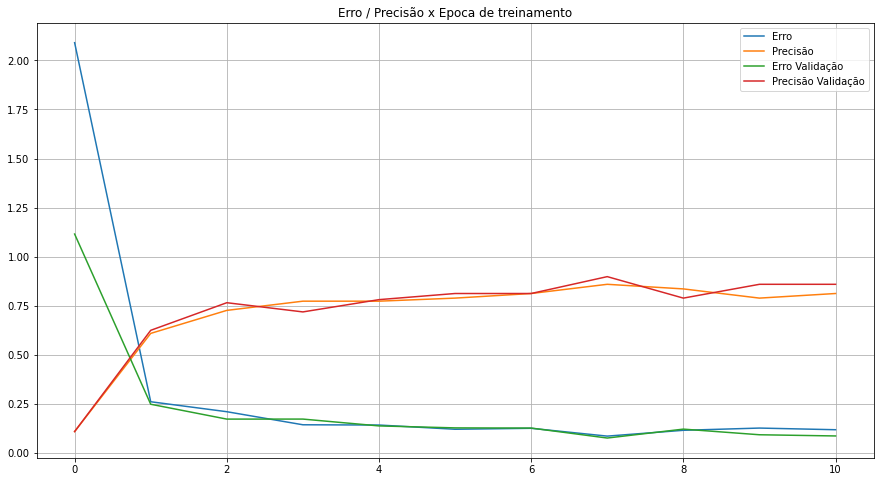

In [12]:
plt.figure(figsize=(15,8))
plt.title("Erro / Precisão x Epoca de treinamento")
plt.plot([np.sum(err) / len(err) for err in train_err], label='Erro');
plt.plot([np.sum(accu) / len(accu) for accu in train_accu], label='Precisão');
plt.plot([np.sum(err) / len(err) for err in eval_err], label='Erro Validação');
plt.plot([np.sum(accu) / len(accu) for accu in eval_accu], label='Precisão Validação');
plt.legend();
plt.grid();

Nota-se o processo de treinamento surtindo efeito sobre o erro médio e a precisão das predições do modelo. Nota-se ainda como o erro médio e precisão das amostras de teste seguem com proximidade as medidas das amostras de treinamento, indicando que não há processo de *overfiting* acontecendo. Falaremos mais sobre esse assunto mais a frente.

Demonstrada a complexidade de se implementar até mesmo um *Multilayer Perceptron* simples matematicamente com o numpy, vamos entender a implementação do mesmo modelo utilizando o Keras, o modulo de alto nível sobre o Tensorflow.

Iniciamos instanciando nosso modelo:

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dense(10)
])

Podemos inferir nosso modelo fazendo sua aplicação (chama a função `__cal__`) nos dados desejados:

In [14]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.81475616,  0.40218908,  1.2794169 ,  0.39987296,  0.31723362,
        -0.03066461, -0.08487135,  1.55153   ,  0.17877293,  0.26677784]],
      dtype=float32)

Para transformar esta previsão (*logists*) em uma distribuição de probabilidades, utilizamos a função [softmax](https://en.wikipedia.org/wiki/Softmax_function):

In [15]:
tf.nn.softmax(predictions).numpy()

array([[0.02529123, 0.08540487, 0.20533255, 0.08520728, 0.07844891,
        0.05539833, 0.0524753 , 0.2695473 , 0.06830526, 0.0745889 ]],
      dtype=float32)

A função de entropia relativa também vem pronta do pacote keras, e neste caso calcularemos as perdas aplicando-a diretamente na saída de nosso modelo (*logits*), sem realizar a aplicação do *softmax*, que acontece internamente.

In [16]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

2.893206

Então compilamos nosso modelo passando os parametros de treinamento desejados.

In [17]:
model.compile(optimizer='sgd', loss=loss_fn, metrics=['accuracy'])

Isto é tudo. O codigo acima instancia e compila um *Multilayer Perceptron* simples. Utilizamos *Stochastic Gradient Descent* como algoritmo de otimização assim como anteriormente. Com o modelo já instanciado, vamos realizar seu treinamento.

In [18]:
train_history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.1924 - accuracy: 0.3174 - val_loss: 2.0252 - val_accuracy: 0.6139
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7112 - accuracy: 0.6329 - val_loss: 1.3146 - val_accuracy: 0.7672
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.0740 - accuracy: 0.7541 - val_loss: 0.8387 - val_accuracy: 0.8157
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.7651 - accuracy: 0.8104 - val_loss: 0.6328 - val_accuracy: 0.8465
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.6174 - accuracy: 0.8391 - val_loss: 0.5266 - val_accuracy: 0.8662
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.5325 - accuracy: 0.8588 - val_loss: 0.4630 - val_accuracy: 0.8810
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.4782 - accuracy: 0.8712 - val_loss: 0.4216 - val_accuracy:

Para avaliar o desempenho do modelo no *dataset* de teste, utilizamos o método `evaluate`.

In [19]:
model.evaluate(x_test,  y_test, verbose=2);

313/313 - 0s - loss: 0.3675 - accuracy: 0.8959


O método *fit* realiza todo o trabalho de propagar os gradientes e atualizar os pesos do modelo para nós. Como parametros deste método, são especificados o tamanho da amostra, o número de épocas de treinamento e os dados de validação a serem utilizados. Este método retorna um objeto história de treinamento onde ficam gravados os dados de treinamento para análise posterior.

O código abaixo utiliza este objeto para plotar os dados de erro e precisão do treinamento

Precisão na última época de treino:  0.8889200091362
Erro médio na última época de treino:  0.3950609266757965
Precisão na última época de validação:  0.8984000086784363
Erro médio na última época de validação:  0.35705575346946716


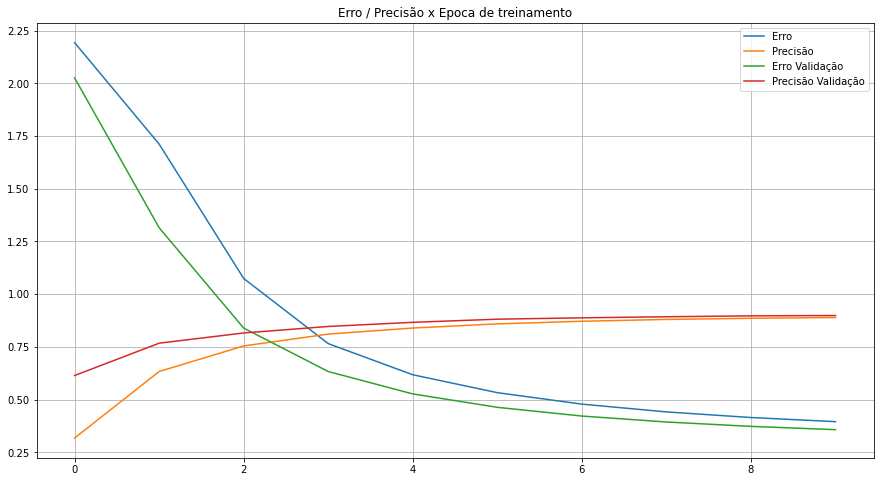

In [20]:
plt.figure(figsize=(15,8))
plt.title("Erro / Precisão x Epoca de treinamento")
plt.plot([err for err in train_history.history['loss']], label='Erro');
plt.plot([accu for accu in train_history.history['accuracy']], label='Precisão');
plt.plot([err for err in train_history.history['val_loss']], label='Erro Validação');
plt.plot([accu for accu in train_history.history['val_accuracy']], label='Precisão Validação');
plt.legend();
plt.grid();

print("Precisão na última época de treino: ", train_history.history['accuracy'][-1])
print("Erro médio na última época de treino: ", train_history.history['loss'][-1])
print("Precisão na última época de validação: ", train_history.history['val_accuracy'][-1])
print("Erro médio na última época de validação: ", train_history.history['val_loss'][-1])

Pode-se perceber que o Keras facilita muito a vida quando se trata de prototipar e testar grafos computacionais como redes neurais. Além disso, a implementação com *backend* em Tensorflow permite ao querar fazer uso da GPU como processador de matrizes, o que acelera o processamento em ordens de magnitude.

Não entraremos em detalhes sobre implementações em tensorflow por se tratar de baixo nível e fora do escopo desde manual. Contudo, muito material esta disponível na internet, a começar pela [documentação](https://www.tensorflow.org/) do Tensorflow, e faremos a cobertura deste assunto em um manual futuro.

[Retornar para o sumário](./index.html)